Приклад простої нейронної мережі

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
C:\Users\User\Documents\article\data_print.py:50: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(fracs, labels=labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)


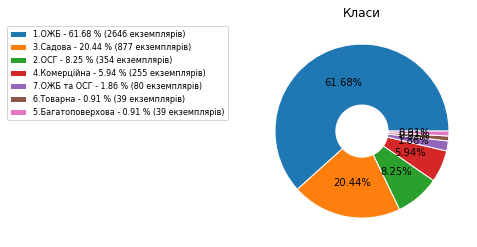

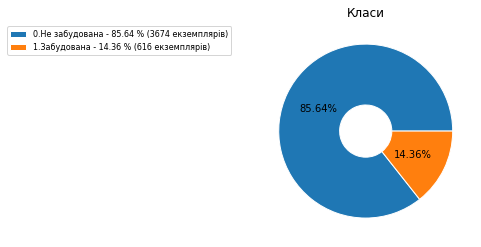

Train on 2874 samples
Epoch 1/5
2874/2874 [==============================] - 2s 731us/sample - loss: 0.7161 - accuracy: 0.7088
Epoch 2/5
2874/2874 [==============================] - 2s 594us/sample - loss: 0.3731 - accuracy: 0.8754
Epoch 3/5
2874/2874 [==============================] - 2s 618us/sample - loss: 0.2374 - accuracy: 0.9294
Epoch 4/5
2874/2874 [==============================] - 2s 571us/sample - loss: 0.1489 - accuracy: 0.9576
Epoch 5/5
2874/2874 [==============================] - 2s 583us/sample - loss: 0.1106 - accuracy: 0.9711
1416/1416 - 0s - loss: 0.2052 - accuracy: 0.9273
test loss: 0.20516728302516507, test acc: 0.9272598624229431
[[1195   18]
 [  85  118]]
Train on 2874 samples
Epoch 1/5
2874/2874 [==============================] - 2s 805us/sample - loss: 1.3955 - accuracy: 0.5612
Epoch 2/5
2874/2874 [==============================] - 2s 649us/sample - loss: 0.6525 - accuracy: 0.8361
Epoch 3/5
2874/2874 [==============================] - 2s 628us/sample - loss: 0.402

In [3]:
import numpy as np
import pandas as pd
import nltk
import re
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from data_print import data_class_display,PCA_text_data_display,pp_conf_matrix
from EstimatorSelectionHelper import GridSearchCV_Classifiers, Best_Classifiers
from ukrainian_stemmer import UkrainianStemmer
from tensorflow.keras.preprocessing.text import Tokenizer

def ua_tokenizer_sklearn(text,stemmer=True):
    """ Tokenizer for Ukrainian language, returns only alphabetic tokens. 
    
    Keyword arguments:
    text -- text for tokenize 
    stemmer -- if True use UkrainianStemmer for stemming words (default True)
          
    """
    text=re.sub(r"""['’"`�]""", '', text)
    text=re.sub(r"""([0-9])([\u0400-\u04FF]|[A-z])""", r"\1 \2", text)
    text=re.sub(r"""([\u0400-\u04FF]|[A-z])([0-9])""", r"\1 \2", text)
    text=re.sub(r"""[\-.,:+*/_]""", ' ', text)
    if stemmer==True:
        return [UkrainianStemmer(word).stem_word() for word in nltk.word_tokenize(text) if word.isalpha()]
    else:
        return [word for word in nltk.word_tokenize(text) if word.isalpha()]
    
    
    
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)   

land_data=pd.read_csv('land_real_estate.csv').replace(np.nan, "")
land_data['text']=land_data['description']+' '+land_data['land_types_source']+' '+land_data['land_types_PcmU']
def land_types_download():    
    data=pd.read_csv('land_types.csv')
    data=data[['id','land_types']]
    data=data.set_index('id')
    data=data.T
    data=data.to_dict('records')
    return (data[0])

land_types=land_types_download()
built_up={0:'Не забудована',1:'Забудована'}

def Data_Augmentation(number):
    unigrams_list=['продаж','земельна', 'ділянка', 'іншої', 'інфраструктура', 'інструменту', 'інвентарю', 'ізумрудє', 'івасюка',
                   'яром', 'яворівського', 'шанове', 'чудова','цін', 'цільових', 'цілу', 'цілорічно', 'участке', 'тільки', 'тухолька', 
                   'турківський', 'твердій','сухий', 'суха', 'сусідніх', 'сусідні', 'судова',  'сторони', 'сто', 'стихії','селі', 'села',  
                   'сайті', 'руська', 'росташування','рокитне', 'розташовану', 'розташований', 'розміщені', 'розміщення', 'розміщений', 'розмірі', 
                   'розділена', 'покупцю', 'показ', 'повідомлення', 'питання']
   
    random.seed(0)
    random_words=[unigrams_list[index] for index in random.sample(range(len(unigrams_list)), len(unigrams_list))]
    tsv='для ведення товарного сільськогосподарського виробництва'
    df = pd.DataFrame(columns=['text','land_types','built_up'])
    for sample_index in range(number):
        df = df.append({'text': tsv+' '+" ".join(random.sample(random_words, random.randint(0,20))),'land_types':6,'built_up':0}, ignore_index=True)
    return df.astype({'text':'object','land_types': 'int32','built_up': 'int32'})

land_data=land_data.append(Data_Augmentation(34), ignore_index=True)
data_class_display(dataframe=land_data,class_column='land_types',expl_lables=land_types)
data_class_display(dataframe=land_data,class_column='built_up',expl_lables=built_up)

X_train_zab, X_test_zab, y_train_zab, y_test_zab=train_test_split(land_data['text'],land_data['built_up'],
                                                                  stratify=land_data['built_up'],
                                                                  test_size=0.33,random_state=0)

X_train, X_test, y_train, y_test=train_test_split(land_data['text'],land_data['land_types'],
                                                  stratify=land_data['land_types'],
                                                  test_size=0.33,random_state=0)


  
def first_model(n_classes): 
    model = tf.keras.models.Sequential([

      tf.keras.layers.Dense(2000, activation='relu'),
      tf.keras.layers.BatchNormalization(),   
      tf.keras.layers.Dropout(0.50),      
      tf.keras.layers.Dense(20, activation='relu'),
      tf.keras.layers.BatchNormalization(),  
      tf.keras.layers.Dropout(0.50),  
      tf.keras.layers.Dense(n_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

def fit_print (X_train, X_test, y_train, y_test,n_classes):
    t = Tokenizer(num_words=2000)
    t.fit_on_texts(X_train)

    X_train = t.texts_to_matrix(X_train, mode='count')
    X_test = t.texts_to_matrix(X_test, mode='count')


    model=first_model(n_classes)
    model.fit(X_train, y_train, epochs=5)
    results = model.evaluate(X_test,  y_test, verbose=2)
    print ('test loss: {0}, test acc: {1}'.format(results[0],results[1]))
    y_pred=model.predict_classes(X_test)   
    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)
    print(con_mat.numpy())

fit_print (X_train_zab, X_test_zab,np.array(y_train_zab), np.array(y_test_zab),2) 
fit_print (X_train, X_test, np.array(y_train)-1, np.array(y_test)-1,7)   




Реалізація решіткового пошуку для підбору гіперпараметрів нейронної мережі

C:\Users\User\Documents\article\data_print.py:50: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(fracs, labels=labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)


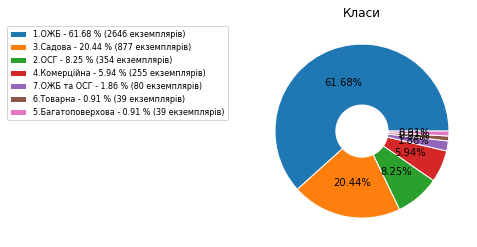

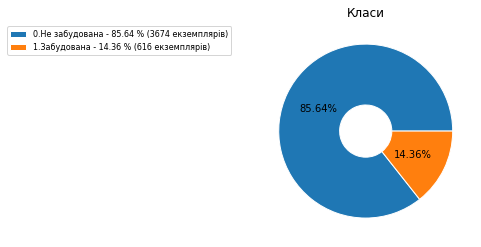

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Running GridSearchCV for KerasClassifier.
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 21.4min
C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 25.5min finished


KerasClassifier
          estimator min_score mean_score max_score   std_score  \
0   KerasClassifier  0.729568  0.767888   0.823372  0.0401727    
1   KerasClassifier  0.711083  0.759428   0.799853  0.0366701    
2   KerasClassifier  0.723602  0.758153   0.802384  0.0328827    
3   KerasClassifier  0.740111  0.756638   0.769957  0.0123936    
4   KerasClassifier  0.713767  0.75094    0.813934  0.0447837    
5   KerasClassifier  0.720611  0.747617   0.761533  0.0190986    
6   KerasClassifier  0.709601  0.74715    0.790193  0.0331298    
7   KerasClassifier  0.711168  0.744035   0.783422  0.0298556    
8   KerasClassifier  0.708643  0.74232    0.802149  0.0424167    
9   KerasClassifier  0.713373  0.740036   0.764327  0.0208692    
10  KerasClassifier  0.715432  0.739695   0.780584  0.0290807    
11  KerasClassifier  0.706017  0.738539   0.796096  0.0408133    
12  KerasClassifier  0.717603  0.735187   0.753635  0.0147227    
13  KerasClassifier  0.717696  0.730928   0.75733   0.018669

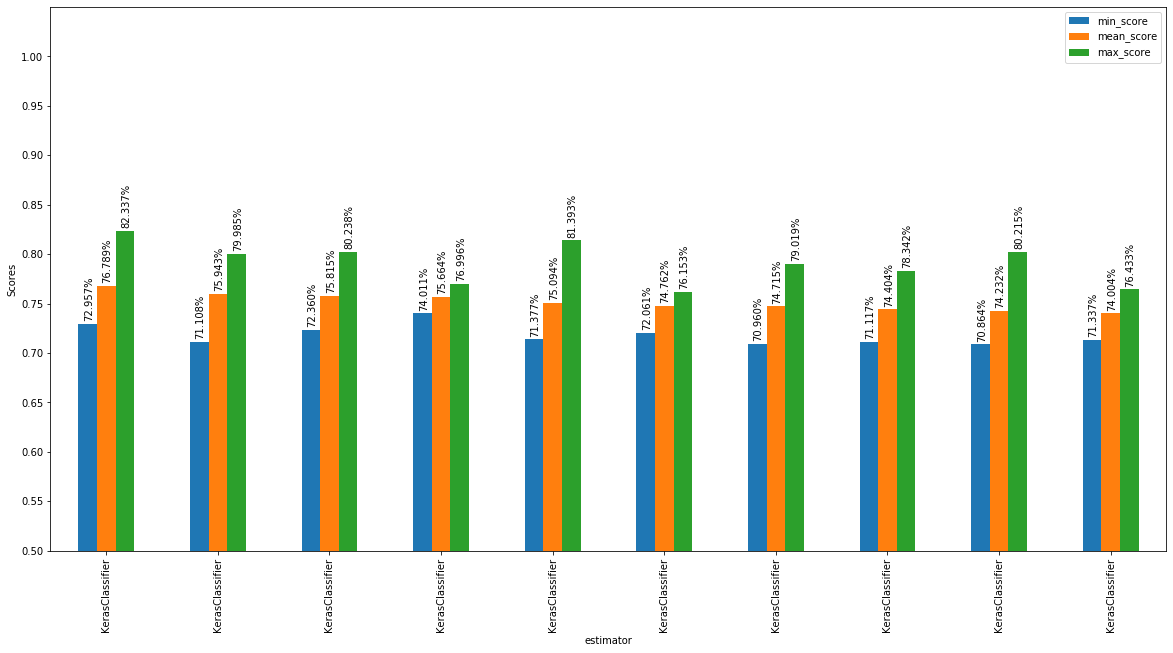

________________________________________________________________________
Running GridSearchCV for KerasClassifier.
Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 11.6min finished


KerasClassifier
          estimator min_score mean_score max_score   std_score  \
0   KerasClassifier  0.79723   0.826307   0.84281   0.0206233    
1   KerasClassifier  0.771555  0.805384   0.838992  0.0275313    
2   KerasClassifier  0.748641  0.787086   0.816258  0.0283728    
3   KerasClassifier  0.752167  0.784266   0.823064  0.029329     
4   KerasClassifier  0.711212  0.781563   0.82033   0.0498318    
5   KerasClassifier  0.741909  0.773901   0.825407  0.0367753    
6   KerasClassifier  0.745009  0.771084   0.79261   0.0196972    
7   KerasClassifier  0.723101  0.7503     0.775632  0.0214863    
8   KerasClassifier  0.73416   0.745092   0.760888  0.011441     
9   KerasClassifier  0.69644   0.739778   0.774253  0.0323795    
10  KerasClassifier  0.688804  0.736822   0.770581  0.0348745    
11  KerasClassifier  0.703836  0.729421   0.762676  0.0246261    
12  KerasClassifier  0.696026  0.718749   0.744245  0.0197829    
13  KerasClassifier  0.631478  0.712942   0.790795  0.065091

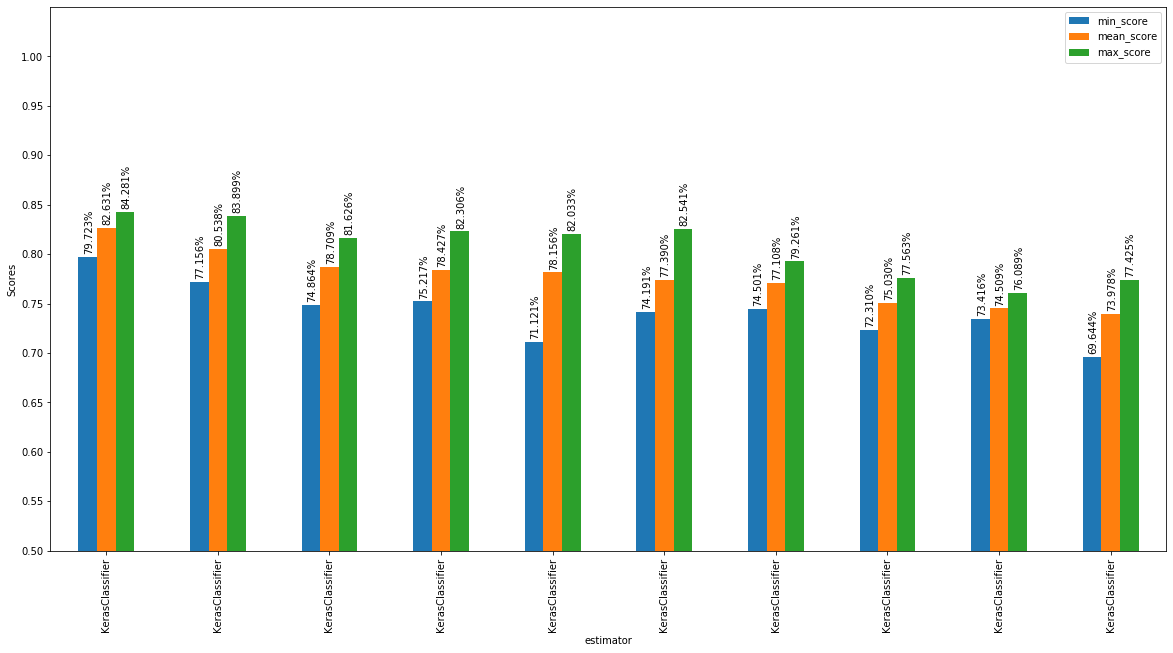

________________________________________________________________________


In [6]:
import numpy as np
import pandas as pd
import nltk
import re
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from data_print import data_class_display,PCA_text_data_display,pp_conf_matrix
from EstimatorSelectionHelper import GridSearchCV_Classifiers, Best_Classifiers
from ukrainian_stemmer import UkrainianStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.svm import LinearSVC

def ua_tokenizer_sklearn(text,stemmer=True):
    """ Tokenizer for Ukrainian language, returns only alphabetic tokens. 
    
    Keyword arguments:
    text -- text for tokenize 
    stemmer -- if True use UkrainianStemmer for stemming words (default True)
          
    """
    text=re.sub(r"""['’"`�]""", '', text)
    text=re.sub(r"""([0-9])([\u0400-\u04FF]|[A-z])""", r"\1 \2", text)
    text=re.sub(r"""([\u0400-\u04FF]|[A-z])([0-9])""", r"\1 \2", text)
    text=re.sub(r"""[\-.,:+*/_]""", ' ', text)
    if stemmer==True:
        return [UkrainianStemmer(word).stem_word() for word in nltk.word_tokenize(text) if word.isalpha()]
    else:
        return [word for word in nltk.word_tokenize(text) if word.isalpha()]
    
    
land_data=pd.read_csv('land_real_estate.csv').replace(np.nan, "")
land_data['text']=land_data['description']+' '+land_data['land_types_source']+' '+land_data['land_types_PcmU']
def land_types_download():    
    data=pd.read_csv('land_types.csv')
    data=data[['id','land_types']]
    data=data.set_index('id')
    data=data.T
    data=data.to_dict('records')
    return (data[0])

land_types=land_types_download()
built_up={0:'Не забудована',1:'Забудована'}

def Data_Augmentation(number):
    unigrams_list=['продаж','земельна', 'ділянка', 'іншої', 'інфраструктура', 'інструменту', 'інвентарю', 'ізумрудє', 'івасюка',
                   'яром', 'яворівського', 'шанове', 'чудова','цін', 'цільових', 'цілу', 'цілорічно', 'участке', 'тільки', 'тухолька', 
                   'турківський', 'твердій','сухий', 'суха', 'сусідніх', 'сусідні', 'судова',  'сторони', 'сто', 'стихії','селі', 'села',  
                   'сайті', 'руська', 'росташування','рокитне', 'розташовану', 'розташований', 'розміщені', 'розміщення', 'розміщений', 'розмірі', 
                   'розділена', 'покупцю', 'показ', 'повідомлення', 'питання']
   
    random.seed(0)
    random_words=[unigrams_list[index] for index in random.sample(range(len(unigrams_list)), len(unigrams_list))]
    tsv='для ведення товарного сільськогосподарського виробництва'
    df = pd.DataFrame(columns=['text','land_types','built_up'])
    for sample_index in range(number):
        df = df.append({'text': tsv+' '+" ".join(random.sample(random_words, random.randint(0,20))),'land_types':6,'built_up':0}, ignore_index=True)
    return df.astype({'text':'object','land_types': 'int32','built_up': 'int32'})

land_data=land_data.append(Data_Augmentation(34), ignore_index=True)
data_class_display(dataframe=land_data,class_column='land_types',expl_lables=land_types)
data_class_display(dataframe=land_data,class_column='built_up',expl_lables=built_up)

X_train_zab, X_test_zab, y_train_zab, y_test_zab=train_test_split(land_data['text'],land_data['built_up'],
                                                                  stratify=land_data['built_up'],
                                                                  test_size=0.33,random_state=0)

X_train, X_test, y_train, y_test=train_test_split(land_data['text'],land_data['land_types'],
                                                  stratify=land_data['land_types'],
                                                  test_size=0.33,random_state=0)


from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import TransformerMixin
def skl_model(units=2000,n_classes=10,n_layers=1,Dropout=0.5): 
    model = tf.keras.Sequential()
    
    model = tf.keras.models.Sequential()
    for n in range(1,n_layers+1):
        model.add(tf.keras.layers.Dense(units/n, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(Dropout))
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

class ToarrayTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

    
y_train=np.array(y_train)
y_test=np.array(y_test)
y_train_zab=np.array(y_train_zab)
y_test_zab=np.array(y_test_zab)
models_params_typy={
        'KerasClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),
                                             ('feature_selection',SelectFromModel(LinearSVC())),
                                              ('ToarrayTransformer',ToarrayTransformer()),
                                             ('clf',KerasClassifier(build_fn=skl_model, verbose=0))]),
                                      {'Vectorizer':[TfidfVectorizer(),CountVectorizer()],
                                       'Vectorizer__ngram_range':[(1,1),(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                      'feature_selection__threshold':[0.2,0.1,0.5],
                                         'clf__units':[1000,500],
                                        'clf__n_classes':[7],                                         
                                         'clf__n_layers':[3,2],
                                         'clf__Dropout':[0.5,0.4],
                                         'clf__epochs':[5],
                                        },
                                     ],   

    
}

  
GridSearchCV_Classifiers(X=X_train, y=y_train-1,
                         models_params=models_params_typy,scoring='f1_macro',cv=3)


models_params_zab={
        'KerasClassifier': [Pipeline([('Vectorizer',TfidfVectorizer()),
                                             ('feature_selection',SelectFromModel(LinearSVC())),
                                              ('ToarrayTransformer',ToarrayTransformer()),
                                             ('clf',KerasClassifier(build_fn=skl_model, verbose=0))]),
                                      {'Vectorizer':[TfidfVectorizer(),CountVectorizer()],
                                       'Vectorizer__ngram_range':[(1,1),(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.2,0.1,0.5],
                                         'clf__units':[1000,500],
                                        'clf__n_classes':[2],                                         
                                         'clf__n_layers':[3,2],
                                         'clf__Dropout':[0.5,0.4],
                                         'clf__epochs':[5],
                                        },
                                     ],   

    
}


GridSearchCV_Classifiers(X=X_train_zab, y=y_train_zab,
                         models_params=models_params_zab,scoring='f1_macro',cv=3)

Нейронна мережа із підібраними гіперпараметрами

C:\Users\User\Documents\article\data_print.py:50: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(fracs, labels=labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)


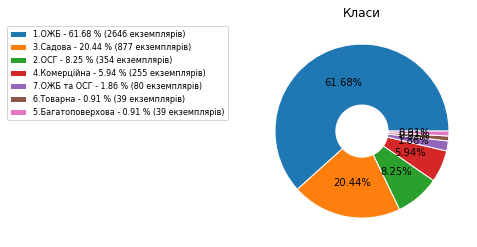

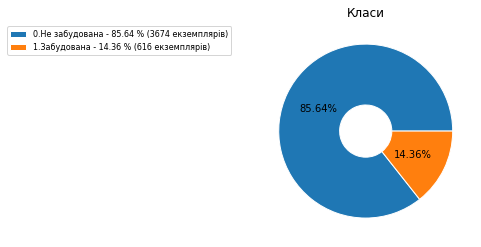

KerasClassifier


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


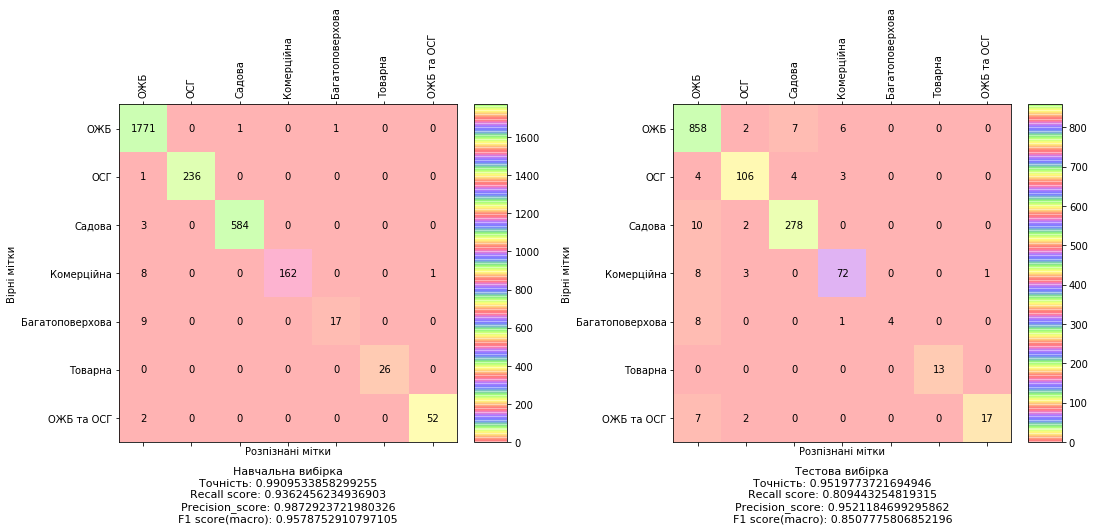

________________________________________________________________________
KerasClassifier


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


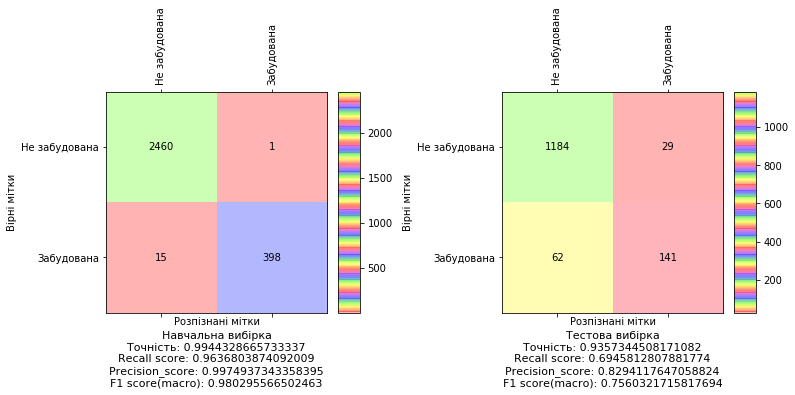

________________________________________________________________________


In [7]:
import numpy as np
import pandas as pd
import nltk
import re
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from data_print import data_class_display,PCA_text_data_display,pp_conf_matrix
from EstimatorSelectionHelper import GridSearchCV_Classifiers, Best_Classifiers
from ukrainian_stemmer import UkrainianStemmer
from tensorflow.keras.preprocessing.text import Tokenizer


def ua_tokenizer_sklearn(text,stemmer=True):
    """ Tokenizer for Ukrainian language, returns only alphabetic tokens. 
    
    Keyword arguments:
    text -- text for tokenize 
    stemmer -- if True use UkrainianStemmer for stemming words (default True)
          
    """
    text=re.sub(r"""['’"`�]""", '', text)
    text=re.sub(r"""([0-9])([\u0400-\u04FF]|[A-z])""", r"\1 \2", text)
    text=re.sub(r"""([\u0400-\u04FF]|[A-z])([0-9])""", r"\1 \2", text)
    text=re.sub(r"""[\-.,:+*/_]""", ' ', text)
    if stemmer==True:
        return [UkrainianStemmer(word).stem_word() for word in nltk.word_tokenize(text) if word.isalpha()]
    else:
        return [word for word in nltk.word_tokenize(text) if word.isalpha()]
    
    
    
land_data=pd.read_csv('land_real_estate.csv').replace(np.nan, "")
land_data['text']=land_data['description']+' '+land_data['land_types_source']+' '+land_data['land_types_PcmU']
def land_types_download():    
    data=pd.read_csv('land_types.csv')
    data=data[['id','land_types']]
    data=data.set_index('id')
    data=data.T
    data=data.to_dict('records')
    return (data[0])

land_types=land_types_download()
built_up={0:'Не забудована',1:'Забудована'}

def Data_Augmentation(number):
    unigrams_list=['продаж','земельна', 'ділянка', 'іншої', 'інфраструктура', 'інструменту', 'інвентарю', 'ізумрудє', 'івасюка',
                   'яром', 'яворівського', 'шанове', 'чудова','цін', 'цільових', 'цілу', 'цілорічно', 'участке', 'тільки', 'тухолька', 
                   'турківський', 'твердій','сухий', 'суха', 'сусідніх', 'сусідні', 'судова',  'сторони', 'сто', 'стихії','селі', 'села',  
                   'сайті', 'руська', 'росташування','рокитне', 'розташовану', 'розташований', 'розміщені', 'розміщення', 'розміщений', 'розмірі', 
                   'розділена', 'покупцю', 'показ', 'повідомлення', 'питання']
   
    random.seed(0)
    random_words=[unigrams_list[index] for index in random.sample(range(len(unigrams_list)), len(unigrams_list))]
    tsv='для ведення товарного сільськогосподарського виробництва'
    df = pd.DataFrame(columns=['text','land_types','built_up'])
    for sample_index in range(number):
        df = df.append({'text': tsv+' '+" ".join(random.sample(random_words, random.randint(0,20))),'land_types':6,'built_up':0}, ignore_index=True)
    return df.astype({'text':'object','land_types': 'int32','built_up': 'int32'})

land_data=land_data.append(Data_Augmentation(34), ignore_index=True)
data_class_display(dataframe=land_data,class_column='land_types',expl_lables=land_types)
data_class_display(dataframe=land_data,class_column='built_up',expl_lables=built_up)

X_train_zab, X_test_zab, y_train_zab, y_test_zab=train_test_split(land_data['text'],land_data['built_up'],
                                                                  stratify=land_data['built_up'],
                                                                  test_size=0.33,random_state=0)

X_train, X_test, y_train, y_test=train_test_split(land_data['text'],land_data['land_types'],
                                                  stratify=land_data['land_types'],
                                                  test_size=0.33,random_state=0)

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.base import TransformerMixin
def skl_model(units=2000,n_classes=10,n_layers=1,Dropout=0.5): 
    model = tf.keras.Sequential()
    
    model = tf.keras.models.Sequential()
    for n in range(1,n_layers+1):
        model.add(tf.keras.layers.Dense(units/n, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(Dropout))
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

class ToarrayTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

    
y_train=np.array(y_train)
y_test=np.array(y_test)
y_train_zab=np.array(y_train_zab)
y_test_zab=np.array(y_test_zab)
models_params_typy={
        'KerasClassifier': [Pipeline([('Vectorizer',CountVectorizer()),
                                             ('feature_selection',SelectFromModel(LinearSVC())),
                                              ('ToarrayTransformer',ToarrayTransformer()),
                                             ('clf',KerasClassifier(build_fn=skl_model, verbose=0))]),
                                      {'Vectorizer__ngram_range':[(1,3)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                      'feature_selection__threshold':[0.2],
                                         'clf__units':[500],
                                        'clf__n_classes':[7],                                         
                                         'clf__n_layers':[2],
                                         'clf__Dropout':[0.4],
                                         'clf__epochs':[5],
                                        },
                                     ],   

    
}

  
Best_Classifiers(X_train, X_test, y_train, y_test,
                         models_params=models_params_typy,expl_lables=land_types)


models_params_zab={
        'KerasClassifier': [Pipeline([('Vectorizer',CountVectorizer()),
                                             ('feature_selection',SelectFromModel(LinearSVC())),
                                              ('ToarrayTransformer',ToarrayTransformer()),
                                             ('clf',KerasClassifier(build_fn=skl_model, verbose=0))]),
                                      {'Vectorizer__ngram_range':[(1,1)],
                                        'Vectorizer__tokenizer':[ua_tokenizer_sklearn],
                                        'feature_selection__threshold':[0.1],
                                         'clf__units':[500],
                                        'clf__n_classes':[2],                                         
                                         'clf__n_layers':[2],
                                         'clf__Dropout':[0.5],
                                         'clf__epochs':[5],
                                        },
                                     ],   

    
}


Best_Classifiers(X_train_zab, X_test_zab, y_train_zab, y_test_zab,
                         models_params=models_params_zab,expl_lables=built_up)


Приклад згорткової нейронної мережі

C:\Users\User\Documents\article\data_print.py:50: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(fracs, labels=labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)


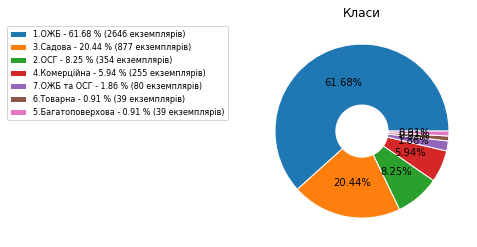

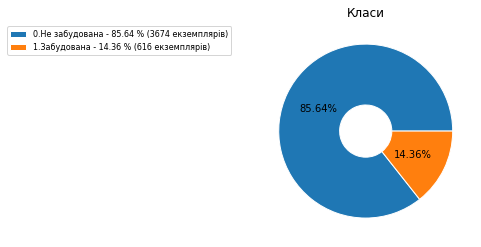

Pad sequences (samples x time)
x_train shape: (2874, 400)
x_test shape: (1416, 400)
Build model...
Train on 2586 samples, validate on 288 samples
Epoch 1/6
2586/2586 [==============================] - 18s 7ms/sample - loss: 0.4355 - accuracy: 0.8546 - val_loss: 0.3997 - val_accuracy: 0.8576
Epoch 2/6
2586/2586 [==============================] - 18s 7ms/sample - loss: 0.2997 - accuracy: 0.8813 - val_loss: 0.2049 - val_accuracy: 0.9340
Epoch 3/6
2586/2586 [==============================] - 17s 7ms/sample - loss: 0.1293 - accuracy: 0.9509 - val_loss: 0.1607 - val_accuracy: 0.9410
Epoch 4/6
2586/2586 [==============================] - 17s 7ms/sample - loss: 0.0781 - accuracy: 0.9718 - val_loss: 0.2130 - val_accuracy: 0.9444
Epoch 5/6
2586/2586 [==============================] - 17s 7ms/sample - loss: 0.0625 - accuracy: 0.9811 - val_loss: 0.2324 - val_accuracy: 0.9306
Epoch 6/6
2586/2586 [==============================] - 17s 7ms/sample - loss: 0.0363 - accuracy: 0.9857 - val_loss: 0.2167 -

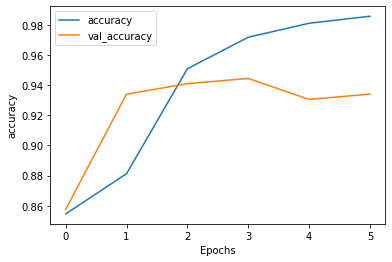

Pad sequences (samples x time)
x_train shape: (2874, 400)
x_test shape: (1416, 400)
Build model...
Train on 2586 samples, validate on 288 samples
Epoch 1/6
2586/2586 [==============================] - 18s 7ms/sample - loss: 1.1947 - accuracy: 0.6121 - val_loss: 0.7535 - val_accuracy: 0.6562
Epoch 2/6
2586/2586 [==============================] - 18s 7ms/sample - loss: 0.6555 - accuracy: 0.8005 - val_loss: 0.5115 - val_accuracy: 0.8507
Epoch 3/6
2586/2586 [==============================] - 18s 7ms/sample - loss: 0.4232 - accuracy: 0.8720 - val_loss: 0.3215 - val_accuracy: 0.9236
Epoch 4/6
2586/2586 [==============================] - 18s 7ms/sample - loss: 0.2397 - accuracy: 0.9393 - val_loss: 0.2479 - val_accuracy: 0.9375
Epoch 5/6
2586/2586 [==============================] - 18s 7ms/sample - loss: 0.1604 - accuracy: 0.9551 - val_loss: 0.2623 - val_accuracy: 0.9340
Epoch 6/6
2586/2586 [==============================] - 18s 7ms/sample - loss: 0.1293 - accuracy: 0.9640 - val_loss: 0.2831 -

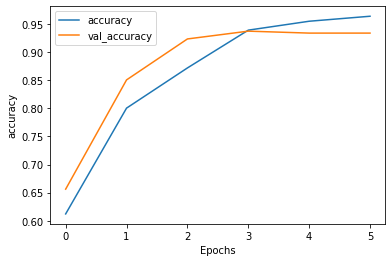

In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from data_print import data_class_display,PCA_text_data_display,pp_conf_matrix
from EstimatorSelectionHelper import GridSearchCV_Classifiers, Best_Classifiers
from ukrainian_stemmer import UkrainianStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.datasets import imdb
    
def ua_tokenizer_sklearn(text,stemmer=True):
    """ Tokenizer for Ukrainian language, returns only alphabetic tokens. 
    
    Keyword arguments:
    text -- text for tokenize 
    stemmer -- if True use UkrainianStemmer for stemming words (default True)
          
    """
    text=re.sub(r"""['’"`�]""", '', text)
    text=re.sub(r"""([0-9])([\u0400-\u04FF]|[A-z])""", r"\1 \2", text)
    text=re.sub(r"""([\u0400-\u04FF]|[A-z])([0-9])""", r"\1 \2", text)
    text=re.sub(r"""[\-.,:+*/_]""", ' ', text)
    if stemmer==True:
        return [UkrainianStemmer(word).stem_word() for word in nltk.word_tokenize(text) if word.isalpha()]
    else:
        return [word for word in nltk.word_tokenize(text) if word.isalpha()]
    
    
    
land_data=pd.read_csv('land_real_estate.csv').replace(np.nan, "")
land_data['text']=land_data['description']+' '+land_data['land_types_source']+' '+land_data['land_types_PcmU']
def land_types_download():    
    data=pd.read_csv('land_types.csv')
    data=data[['id','land_types']]
    data=data.set_index('id')
    data=data.T
    data=data.to_dict('records')
    return (data[0])

land_types=land_types_download()
built_up={0:'Не забудована',1:'Забудована'}

def Data_Augmentation(number):
    unigrams_list=['продаж','земельна', 'ділянка', 'іншої', 'інфраструктура', 'інструменту', 'інвентарю', 'ізумрудє', 'івасюка',
                   'яром', 'яворівського', 'шанове', 'чудова','цін', 'цільових', 'цілу', 'цілорічно', 'участке', 'тільки', 'тухолька', 
                   'турківський', 'твердій','сухий', 'суха', 'сусідніх', 'сусідні', 'судова',  'сторони', 'сто', 'стихії','селі', 'села',  
                   'сайті', 'руська', 'росташування','рокитне', 'розташовану', 'розташований', 'розміщені', 'розміщення', 'розміщений', 'розмірі', 
                   'розділена', 'покупцю', 'показ', 'повідомлення', 'питання']
   
    random.seed(0)
    random_words=[unigrams_list[index] for index in random.sample(range(len(unigrams_list)), len(unigrams_list))]
    tsv='для ведення товарного сільськогосподарського виробництва'
    df = pd.DataFrame(columns=['text','land_types','built_up'])
    for sample_index in range(number):
        df = df.append({'text': tsv+' '+" ".join(random.sample(random_words, random.randint(0,20))),'land_types':6,'built_up':0}, ignore_index=True)
    return df.astype({'text':'object','land_types': 'int32','built_up': 'int32'})

land_data=land_data.append(Data_Augmentation(34), ignore_index=True)
data_class_display(dataframe=land_data,class_column='land_types',expl_lables=land_types)
data_class_display(dataframe=land_data,class_column='built_up',expl_lables=built_up)

X_train_zab, X_test_zab, y_train_zab, y_test_zab=train_test_split(land_data['text'],land_data['built_up'],
                                                                  stratify=land_data['built_up'],
                                                                  test_size=0.33,random_state=0)

X_train, X_test, y_train, y_test=train_test_split(land_data['text'],land_data['land_types'],
                                                  stratify=land_data['land_types'],
                                                  test_size=0.33,random_state=0)

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()



def fit_print_conv(X_train, X_test, y_train, y_test,n_classes): 

    # set parameters:
    max_features = 5000
    maxlen = 400
    batch_size = 32
    embedding_dims = 150
    filters = 500
    kernel_size = 3
    hidden_dims = 250
    epochs = 6
    
    
    t = Tokenizer(num_words=max_features)
    t.fit_on_texts(X_train)    
    X_train = t.texts_to_sequences(X_train)
    X_test = t.texts_to_sequences(X_test)

    
    print('Pad sequences (samples x time)')
    X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
    X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
    print('x_train shape:', X_train.shape)
    print('x_test shape:', X_test.shape)
    
    X_train, X_val, y_train, y_val=train_test_split(X_train,y_train,
                                                  stratify=y_train,
                                                  test_size=0.10,random_state=42)

    
    print('Build model...')
    model = Sequential()

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(max_features,
                        embedding_dims,
                        input_length=maxlen))
    model.add(Dropout(0.2))

    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='same',
                     activation='relu'))
    model.add(Dropout(0.1))
    model.add(Conv1D(filters//10,
                     kernel_size,
                     padding='same',
                     activation='relu'))
    model.add(Dropout(0.1))
   
    # we use max pooling:
    model.add(GlobalMaxPooling1D())

    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(n_classes))
    model.add(Activation('sigmoid'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_val, y_val))
    
    results = model.evaluate(X_test,  y_test, verbose=2)
    print ('test loss: {0}, test acc: {1}'.format(results[0],results[1]))
    y_pred=model.predict_classes(X_test)   
    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)
    print(con_mat.numpy())
    plot_graphs(history, 'accuracy')
    


    
    
fit_print_conv (X_train_zab, X_test_zab,np.array(y_train_zab), np.array(y_test_zab),2) 
fit_print_conv (X_train, X_test, np.array(y_train)-1, np.array(y_test)-1,7)   




Приклад рекорентної нейронної мережі

C:\Users\User\Documents\article\data_print.py:50: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(fracs, labels=labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)


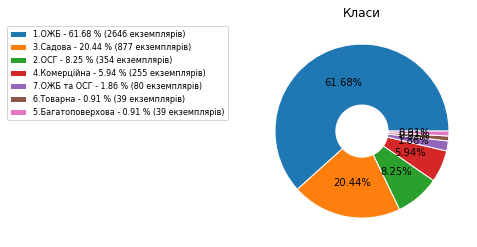

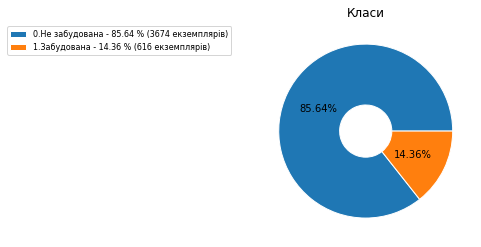

Pad sequences (samples x time)
x_train shape: (2874, 400)
x_test shape: (1416, 400)
Build model...
Train on 2586 samples, validate on 288 samples
Epoch 1/5
2586/2586 [==============================] - 24s 9ms/sample - loss: 0.4483 - accuracy: 0.8531 - val_loss: 0.4096 - val_accuracy: 0.8576
Epoch 2/5
2586/2586 [==============================] - 22s 9ms/sample - loss: 0.4058 - accuracy: 0.8561 - val_loss: 0.4192 - val_accuracy: 0.8576
Epoch 3/5
2586/2586 [==============================] - 22s 8ms/sample - loss: 0.2882 - accuracy: 0.8948 - val_loss: 0.2273 - val_accuracy: 0.9236
Epoch 4/5
2586/2586 [==============================] - 23s 9ms/sample - loss: 0.1716 - accuracy: 0.9490 - val_loss: 0.2336 - val_accuracy: 0.9167
Epoch 5/5
2586/2586 [==============================] - 22s 8ms/sample - loss: 0.1186 - accuracy: 0.9640 - val_loss: 0.1900 - val_accuracy: 0.9306
1416/1416 - 4s - loss: 0.1975 - accuracy: 0.9237
test loss: 0.19753522800523682, test acc: 0.9237288236618042
[[1142   71]
 

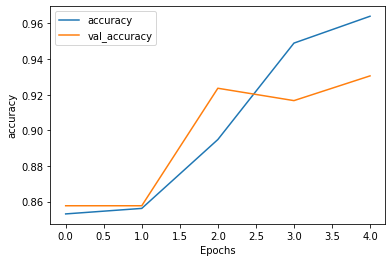

Pad sequences (samples x time)
x_train shape: (2874, 400)
x_test shape: (1416, 400)
Build model...
Train on 2586 samples, validate on 288 samples
Epoch 1/10
2586/2586 [==============================] - 104s 40ms/sample - loss: 1.2290 - accuracy: 0.6145 - val_loss: 1.1404 - val_accuracy: 0.6181
Epoch 2/10
2586/2586 [==============================] - 106s 41ms/sample - loss: 0.9951 - accuracy: 0.6323 - val_loss: 0.7462 - val_accuracy: 0.8194
Epoch 3/10
2586/2586 [==============================] - 108s 42ms/sample - loss: 0.5626 - accuracy: 0.8561 - val_loss: 0.4532 - val_accuracy: 0.8889
Epoch 4/10
2586/2586 [==============================] - 110s 42ms/sample - loss: 0.4085 - accuracy: 0.9045 - val_loss: 0.4153 - val_accuracy: 0.8889
Epoch 5/10
2586/2586 [==============================] - 110s 43ms/sample - loss: 0.3263 - accuracy: 0.9172 - val_loss: 0.4220 - val_accuracy: 0.8819
Epoch 6/10
2586/2586 [==============================] - 110s 42ms/sample - loss: 0.2639 - accuracy: 0.9312 - 

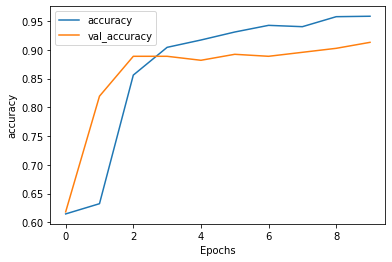

In [3]:
import numpy as np
import pandas as pd
import nltk
import re
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from data_print import data_class_display,PCA_text_data_display,pp_conf_matrix
from EstimatorSelectionHelper import GridSearchCV_Classifiers, Best_Classifiers
from ukrainian_stemmer import UkrainianStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.datasets import imdb
    
def ua_tokenizer_sklearn(text,stemmer=True):
    """ Tokenizer for Ukrainian language, returns only alphabetic tokens. 
    
    Keyword arguments:
    text -- text for tokenize 
    stemmer -- if True use UkrainianStemmer for stemming words (default True)
          
    """
    text=re.sub(r"""['’"`�]""", '', text)
    text=re.sub(r"""([0-9])([\u0400-\u04FF]|[A-z])""", r"\1 \2", text)
    text=re.sub(r"""([\u0400-\u04FF]|[A-z])([0-9])""", r"\1 \2", text)
    text=re.sub(r"""[\-.,:+*/_]""", ' ', text)
    if stemmer==True:
        return [UkrainianStemmer(word).stem_word() for word in nltk.word_tokenize(text) if word.isalpha()]
    else:
        return [word for word in nltk.word_tokenize(text) if word.isalpha()]
    
    
    
land_data=pd.read_csv('land_real_estate.csv').replace(np.nan, "")
land_data['text']=land_data['description']+' '+land_data['land_types_source']+' '+land_data['land_types_PcmU']
def land_types_download():    
    data=pd.read_csv('land_types.csv')
    data=data[['id','land_types']]
    data=data.set_index('id')
    data=data.T
    data=data.to_dict('records')
    return (data[0])

land_types=land_types_download()
built_up={0:'Не забудована',1:'Забудована'}

def Data_Augmentation(number):
    unigrams_list=['продаж','земельна', 'ділянка', 'іншої', 'інфраструктура', 'інструменту', 'інвентарю', 'ізумрудє', 'івасюка',
                   'яром', 'яворівського', 'шанове', 'чудова','цін', 'цільових', 'цілу', 'цілорічно', 'участке', 'тільки', 'тухолька', 
                   'турківський', 'твердій','сухий', 'суха', 'сусідніх', 'сусідні', 'судова',  'сторони', 'сто', 'стихії','селі', 'села',  
                   'сайті', 'руська', 'росташування','рокитне', 'розташовану', 'розташований', 'розміщені', 'розміщення', 'розміщений', 'розмірі', 
                   'розділена', 'покупцю', 'показ', 'повідомлення', 'питання']
   
    random.seed(0)
    random_words=[unigrams_list[index] for index in random.sample(range(len(unigrams_list)), len(unigrams_list))]
    tsv='для ведення товарного сільськогосподарського виробництва'
    df = pd.DataFrame(columns=['text','land_types','built_up'])
    for sample_index in range(number):
        df = df.append({'text': tsv+' '+" ".join(random.sample(random_words, random.randint(0,20))),'land_types':6,'built_up':0}, ignore_index=True)
    return df.astype({'text':'object','land_types': 'int32','built_up': 'int32'})

land_data=land_data.append(Data_Augmentation(34), ignore_index=True)
data_class_display(dataframe=land_data,class_column='land_types',expl_lables=land_types)
data_class_display(dataframe=land_data,class_column='built_up',expl_lables=built_up)

X_train_zab, X_test_zab, y_train_zab, y_test_zab=train_test_split(land_data['text'],land_data['built_up'],
                                                                  stratify=land_data['built_up'],
                                                                  test_size=0.33,random_state=0)

X_train, X_test, y_train, y_test=train_test_split(land_data['text'],land_data['land_types'],
                                                  stratify=land_data['land_types'],
                                                  test_size=0.33,random_state=0)
 

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()



def fit_print_rnn(X_train, X_test, y_train, y_test,n_classes,units,epochs): 

    # set parameters:
    max_features = 5000
    maxlen = 400
    batch_size = 32
    embedding_dims = 100
    kernel_size = 3
    hidden_dims = 250    
    
    
    t = Tokenizer(num_words=max_features)
    t.fit_on_texts(X_train)    
    X_train = t.texts_to_sequences(X_train)
    X_test = t.texts_to_sequences(X_test)

    
    print('Pad sequences (samples x time)')
    X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
    X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
    print('x_train shape:', X_train.shape)
    print('x_test shape:', X_test.shape)
    
    X_train, X_val, y_train, y_val=train_test_split(X_train,y_train,
                                                  stratify=y_train,
                                                  test_size=0.10,random_state=42)

    
    print('Build model...')
    model = Sequential()
    model.add(Embedding(max_features,
                        embedding_dims, 
                        input_length=maxlen
                       ))
    model.add(Dropout(0.2))
    
    model.add(tf.keras.layers.LSTM(units,  return_sequences=True, dropout=0.4))
    model.add(tf.keras.layers.LSTM(units//2,  dropout=0.4))
    model.add(Dense(n_classes, activation='sigmoid'))


    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_val, y_val))
    results = model.evaluate(X_test,  y_test, verbose=2)
    print ('test loss: {0}, test acc: {1}'.format(results[0],results[1]))
    y_pred=model.predict_classes(X_test)   
    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)
    print(con_mat.numpy())
    plot_graphs(history, 'accuracy')
    
fit_print_rnn (X_train_zab, X_test_zab,np.array(y_train_zab), np.array(y_test_zab),2,64,5) 
fit_print_rnn (X_train, X_test, np.array(y_train)-1, np.array(y_test)-1,7,196,10) 

Приклад побудови моделі word2vec

C:\Users\User\Documents\article\data_print.py:50: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(fracs, labels=labels, loc='best', bbox_to_anchor=(-0.1, 1.), fontsize=8)


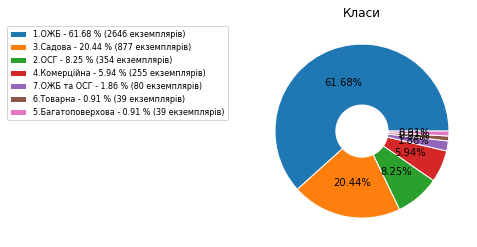

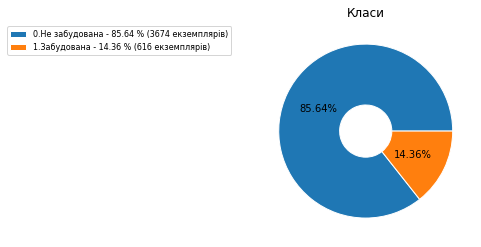

Word2Vec
Слово 'ділянка' -  [('мрію', 0.12444563210010529), ('присвоєний', 0.1221877932548523), ('горы', 0.1125452071428299), ('господарства', 0.10289157181978226), ('неї', 0.10067432373762131), ('пилипец', 0.10029172897338867), ('зовсім', 0.09704037010669708), ('потічок', 0.09689418971538544), ('широка', 0.09640874713659286), ('проходить', 0.09575922787189484)]
Слово 'земельна' -  [('увазі', 0.1161714568734169), ('хуст', 0.10643313825130463), ('зведення', 0.10264638066291809), ('початкова', 0.1005157008767128), ('зведено', 0.09715737402439117), ('гакадастровий', 0.095176562666893), ('тзов', 0.09422482550144196), ('колії', 0.09348714351654053), ('суховолі', 0.09305611252784729), ('електричка', 0.09153789281845093)]
Слово 'будинка' -  [('різного', 0.11177098006010056), ('садочка', 0.10531207919120789), ('приватизований', 0.10071966052055359), ('облаштування', 0.0977017879486084), ('станция', 0.09768658876419067), ('плай', 0.09451328217983246), ('жилыми', 0.08689279854297638), ('спарку',

In [4]:
import numpy as np
import pandas as pd
import nltk
import re
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from data_print import data_class_display,PCA_text_data_display,pp_conf_matrix
from EstimatorSelectionHelper import GridSearchCV_Classifiers, Best_Classifiers
from ukrainian_stemmer import UkrainianStemmer
from tensorflow.keras.preprocessing.text import Tokenizer


from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.datasets import imdb

from gensim.models.word2vec import Word2Vec
from sklearn.preprocessing import scale

    
def ua_tokenizer(text,ua_stemmer=True,stop_words=[]):
    """ Tokenizer for Ukrainian language, returns only alphabetic tokens. 
    
    Keyword arguments:
    text -- text for tokenize 
    ua_stemmer -- if True use UkrainianStemmer for stemming words (default True)
    stop_words -- list of stop words (default [])
        
    """
    tokenized_list=[]
    text=re.sub(r"""['’"`�]""", '', text)
    text=re.sub(r"""([0-9])([\u0400-\u04FF]|[A-z])""", r"\1 \2", text)
    text=re.sub(r"""([\u0400-\u04FF]|[A-z])([0-9])""", r"\1 \2", text)
    text=re.sub(r"""[\-.,:+*/_]""", ' ', text)
    for word in nltk.word_tokenize(text): 
        if word.isalpha():
            word=word.lower() 
            if ua_stemmer is True:      
                word=UkrainianStemmer(word).stem_word()
            if word not in stop_words:
                tokenized_list.append(word) 
    return tokenized_list
    
    
    
land_data=pd.read_csv('land_real_estate.csv').replace(np.nan, "")
land_data['text']=land_data['description']+' '+land_data['land_types_source']+' '+land_data['land_types_PcmU']
def land_types_download():    
    data=pd.read_csv('land_types.csv')
    data=data[['id','land_types']]
    data=data.set_index('id')
    data=data.T
    data=data.to_dict('records')
    return (data[0])

land_types=land_types_download()
built_up={0:'Не забудована',1:'Забудована'}

def Data_Augmentation(number):
    unigrams_list=['продаж','земельна', 'ділянка', 'іншої', 'інфраструктура', 'інструменту', 'інвентарю', 'ізумрудє', 'івасюка',
                   'яром', 'яворівського', 'шанове', 'чудова','цін', 'цільових', 'цілу', 'цілорічно', 'участке', 'тільки', 'тухолька', 
                   'турківський', 'твердій','сухий', 'суха', 'сусідніх', 'сусідні', 'судова',  'сторони', 'сто', 'стихії','селі', 'села',  
                   'сайті', 'руська', 'росташування','рокитне', 'розташовану', 'розташований', 'розміщені', 'розміщення', 'розміщений', 'розмірі', 
                   'розділена', 'покупцю', 'показ', 'повідомлення', 'питання']
   
    random.seed(0)
    random_words=[unigrams_list[index] for index in random.sample(range(len(unigrams_list)), len(unigrams_list))]
    tsv='для ведення товарного сільськогосподарського виробництва'
    df = pd.DataFrame(columns=['text','land_types','built_up'])
    for sample_index in range(number):
        df = df.append({'text': tsv+' '+" ".join(random.sample(random_words, random.randint(0,20))),'land_types':6,'built_up':0}, ignore_index=True)
    return df.astype({'text':'object','land_types': 'int32','built_up': 'int32'})

land_data=land_data.append(Data_Augmentation(34), ignore_index=True)
data_class_display(dataframe=land_data,class_column='land_types',expl_lables=land_types)
data_class_display(dataframe=land_data,class_column='built_up',expl_lables=built_up)

X_train_zab, X_test_zab, y_train_zab, y_test_zab=train_test_split(land_data['text'],land_data['built_up'],
                                                                  stratify=land_data['built_up'],
                                                                  test_size=0.33,random_state=0)

X_train, X_test, y_train, y_test=train_test_split(land_data['text'],land_data['land_types'],
                                                  stratify=land_data['land_types'],
                                                  test_size=0.33,random_state=0)

 
def dataset_to_Word2Vec(X,model_dir='word2vec_gensim.bin',ua_stemmer=False):
    print('Word2Vec')
    try:
        model = Word2Vec.load(model_dir)
    except IOError:
        X=X.map(lambda x: ua_tokenizer(x,ua_stemmer=ua_stemmer))
        model = Word2Vec(X, size=1000, min_count=10, workers=-1)        
        model.train(X, total_examples=model.corpus_count, epochs=10000)
        model.init_sims(replace=True)
        model.save(model_dir)
    finally:
        return model

model = dataset_to_Word2Vec(land_data['text'],model_dir='word2vec_gensim_all_corpus.bin')

print ("Слово 'ділянка' - ", model.wv.most_similar('ділянка'))
print ("Слово 'земельна' - ",model.wv.most_similar('земельна'))  
print ("Слово 'будинка' - ",model.wv.most_similar('будинка'))  


